<a href="https://colab.research.google.com/github/JaeYeonBang/ML_regression/blob/main/regression-house-prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import sys

import math

%matplotlib inline

In [2]:
!pip install pycaret

In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeyeonbang","key":"18b04a1488a2e8a9ca8eda435a8fe67c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         58           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         91           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge       1193           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        164           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1962           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14331           False  
house-pr

In [8]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip house-prices-advanced-regression-techniques

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [10]:
!ls

data_description.txt				 sample_submission.csv
house-prices-advanced-regression-techniques.zip  test.csv
kaggle.json					 train.csv
sample_data


In [61]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
sub =  pd.read_csv('./sample_submission.csv')

In [62]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [63]:
df_train.drop('Id', axis = 1 , inplace = True)
df_test.drop('Id', axis = 1 , inplace = True)
df_train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

## Data preparing

In [64]:
CATEGORICAL_FEATURES_NAMES = []
NUMERIC_FEATURES_NAMES = []


for i, dtype in enumerate(df_train.dtypes):
    if dtype == 'float64' or dtype == 'int64':
        NUMERIC_FEATURES_NAMES.append(df_train.dtypes.index[i])
    elif dtype == 'object':
        CATEGORICAL_FEATURES_NAMES.append(df_train.dtypes.index[i])
print("numeric features : ", NUMERIC_FEATURES_NAMES)
print("categorical features : ", CATEGORICAL_FEATURES_NAMES)

numeric features :  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
categorical features :  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu

In [65]:
CATEGORICAL_FEATURES_NAMES.append('MSSubClass')
NUMERIC_FEATURES_NAMES.remove('MSSubClass')
NUMERIC_FEATURES_NAMES.remove('SalePrice')
TARGET_FEATURE_NAME = 'SalePrice' 

In [66]:
df_train[CATEGORICAL_FEATURES_NAMES] = df_train[CATEGORICAL_FEATURES_NAMES].astype("category")

In [67]:
df_test[CATEGORICAL_FEATURES_NAMES] = df_test[CATEGORICAL_FEATURES_NAMES].astype("category")


In [19]:
sys.getsizeof(df_test)

496415

Text(0.5, 1.0, 'SalePrice distribution')

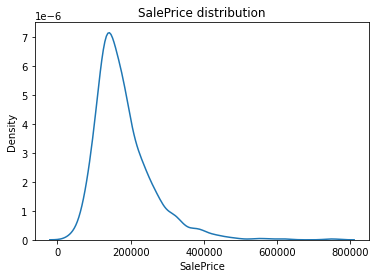

In [20]:
 sns.kdeplot(data = df_train[TARGET_FEATURE_NAME]).set_title('SalePrice distribution')

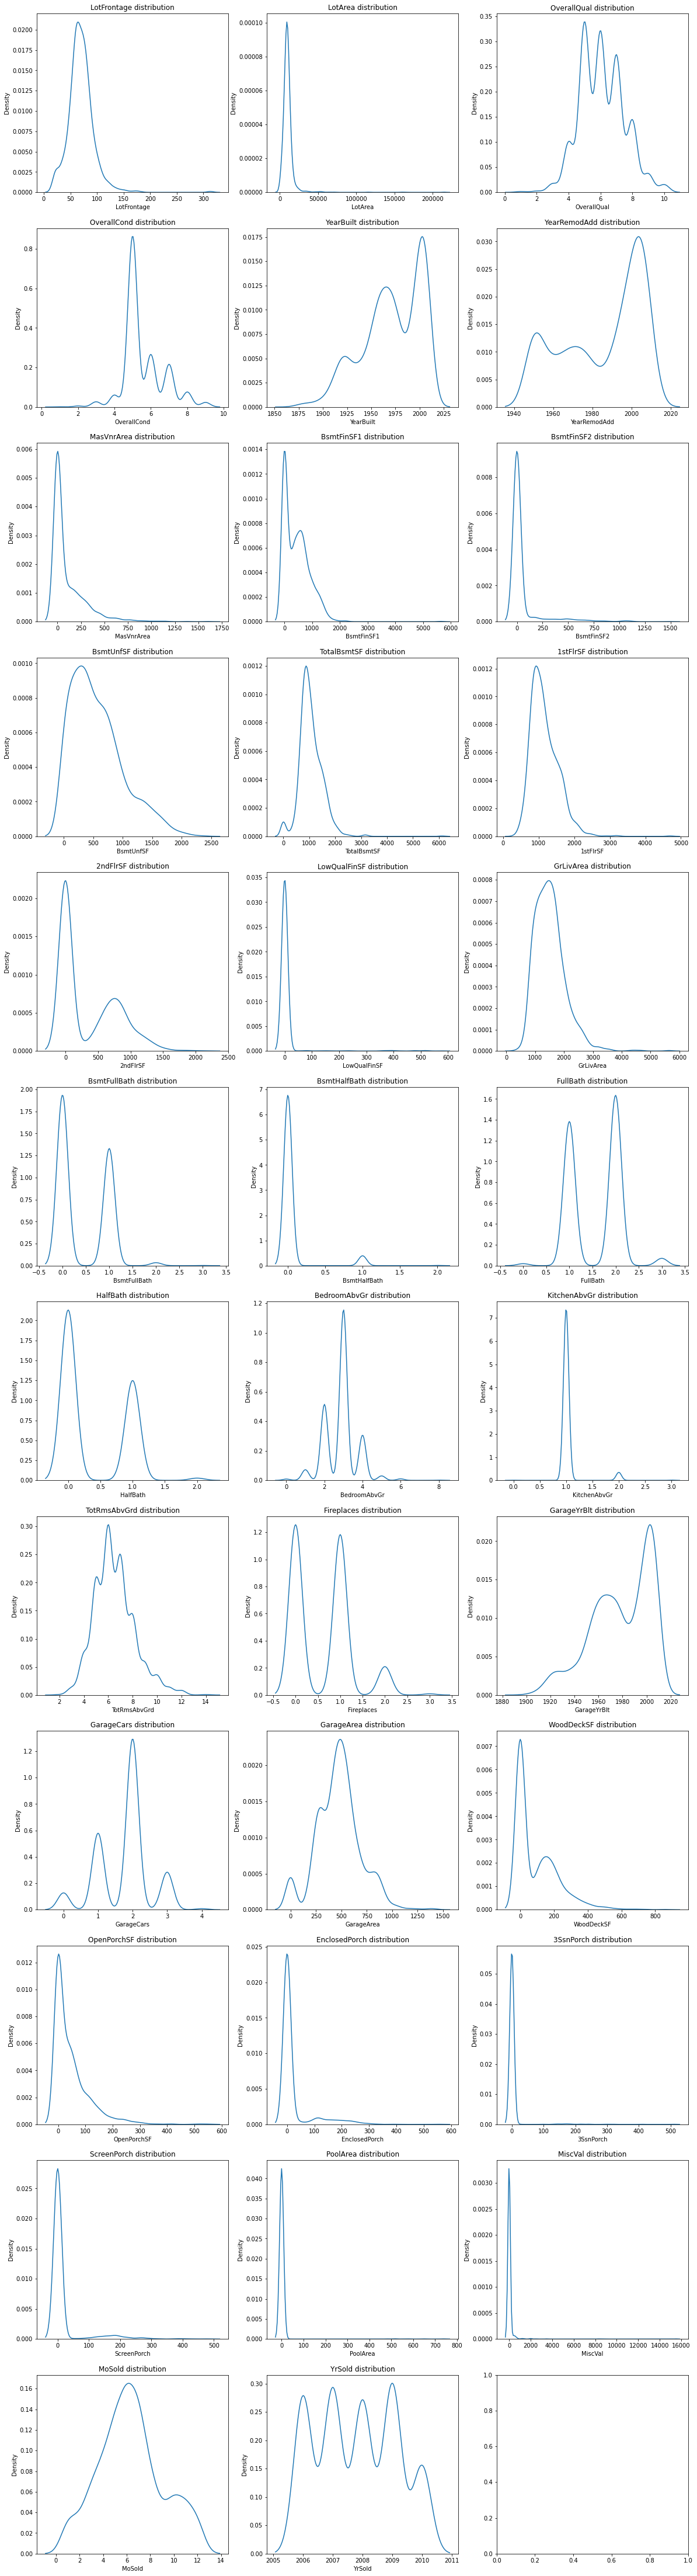

In [22]:
def show_numeric_distribution (data = None, FEATURES_NAME = None, target = None, row = 0, col = 0, figsize = (18, 18), ):

    fig, ax = plt.subplots(row,col, figsize = figsize)
    for i, feature in enumerate( FEATURES_NAME):
        sns.kdeplot(data = data[feature], ax = ax[math.floor(i/col), i%col]).set_title(f'{feature} distribution')
    fig.show()

show_numeric_distribution(data = df_train, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
                      row =  len(NUMERIC_FEATURES_NAMES)//3 + 1, col = 3, figsize = (20, 80)) 

In [ ]:
# for feature in NUMERIC_FEATURES_NAMES:
#     if abs(df_train[feature].skew()) > 0.5:
#         NEED_TO_BE_LOGGED_FEATURES_NAMES.append(feature)
    

In [ ]:
# NEED_TO_BE_LOGGED_FEATURES_NAMES

In [ ]:
# df_train_logged =  df_train
# df_train[TARGET_FEATURE_NAME] = np.log1p(df_train[TARGET_FEATURE_NAME])
# for features in NEED_TO_BE_LOGGED_FEATURES_NAMES : 
#     df_train_logged[features] = np.log1p(df_train[features])

In [ ]:
# show_numeric_distribution(data = df_train_logged, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
#                       row =  len(NUMERIC_FEATURES_NAMES)//3 + 1, col = 3, figsize = (20, 80)) 

In [68]:
df_train[TARGET_FEATURE_NAME] = np.log1p(df_train[TARGET_FEATURE_NAME])

Text(0.5, 1.0, 'SalePrice distribution')

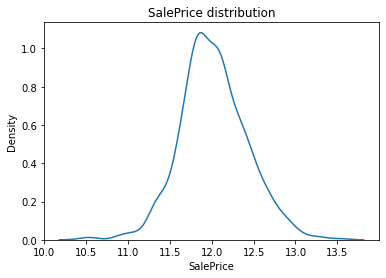

In [25]:
 sns.kdeplot(data = df_train[TARGET_FEATURE_NAME]).set_title('SalePrice distribution')

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler =  MinMaxScaler()
# fitted = scaler.fit(df_train[NUMERIC_FEATURES_NAMES])
# normalized_np_train=scaler.transform(df_train[NUMERIC_FEATURES_NAMES])
# normalized_df_train = pd.DataFrame(normalized_np_train)
# normalized_df_train.head(3)

In [29]:
def max_min_scaler(df, FEATURES):
  temp = df
  temp[FEATURES] = (temp[FEATURES] - temp[FEATURES].min()) / (temp[FEATURES].max() - temp[FEATURES].min())
  return temp
df_train_scaled = max_min_scaler(df_train , NUMERIC_FEATURES_NAMES)
df_train_scaled = max_min_scaler(df_train , 'SalePrice')
df_train_scaled.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,0.150685,0.033420,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,0.090909,0.50,WD,Normal,0.581428
1,20,RL,0.202055,0.038795,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,0.363636,0.25,WD,Normal,0.536316
2,60,RL,0.160959,0.046507,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,0.727273,0.50,WD,Normal,0.604026


In [51]:
df_train[NUMERIC_FEATURES_NAMES].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
def show_swarmplots(data = None, col = 5, FEATURES_NAME = None, figsize = (30, 30)):
  temp = data[FEATURES_NAME]
  len_num = len(temp.columns)
  i = 0
  while i < len_num:
  
    sns.violinplot(x="variable", y="value", data=pd.melt(temp.iloc[: , i : i+col]))
    i += col
    plt.show()

show_swarmplots(data = df_train ,col = 5, FEATURES_NAME = NUMERIC_FEATURES_NAMES, figsize = (18, 18))

In [ ]:
def show_boxplots(data = None, col = 5, FEATURES_NAME = None, figsize = (30, 30)):
  temp = data[FEATURES_NAME]
  len_num = len(temp.columns)
  i = 0
  while i < len_num:
    
    sns.boxplot(x="variable", y="value", data=pd.melt(temp.iloc[: , i : i+col]))
    i += col
    plt.show()

show_boxplots(data = df_train ,col = 5, FEATURES_NAME = NUMERIC_FEATURES_NAMES, figsize = (18, 18))

In [ ]:
def show_regression_plots (data = None, FEATURES_NAME = None, target = None, row = 0, col = 0, figsize = (18, 18) ):

    fig, ax = plt.subplots(row,col, figsize = figsize)
    for i, feature in enumerate( FEATURES_NAME):
        sns.regplot(x = feature, y = target ,data = data, ax = ax[math.floor(i/col), i%col]).set_title(f'{feature} distribution')
    fig.show()

show_regression_plots(data = df_train, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
                      row =  len(NUMERIC_FEATURES_NAMES)//3 + 1 , col = 3, figsize = (20, 80)) 

### processing NAN

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [146]:
df_train_na = (df_train.isnull().sum() / len(df_train)) * 100
df_train_na = df_train_na.drop(df_train_na[df_train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :df_train_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1455    NaN
1456    NaN
1457    NaN
1458    NaN
1459    NaN
Name: PoolQC, Length: 1460, dtype: category
Categories (4, object): ['Ex', 'Fa', 'Gd', 'None']

In [158]:
#df_train['PoolQC'].cat.add_categories('None',inplace = True)
df_train['PoolQC'].fillna('None', inplace = True)
df_train_na.drop('PoolQC')


MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [27]:
HAVE_NA_FEATURES=df_train.isna().sum().sort_values(ascending = False)
print(HAVE_NA_FEATURES)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
Fireplaces         0
Functional         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
dtype: int64


1460

In [145]:
NA_PERCENTAGE = HAVE_NA_FEATURES / len(df_train.index)

TypeError: ignored

In [ ]:
for i, dtype in enumerate(df_train.dtypes):
    if dtype == 'float64' or dtype == 'int64':
        NUMERIC_FEATURES_NAMES.append(df_train.dtypes.index[i])
    elif dtype == 'object':
        CATEGORICAL_FEATURES_NAMES.append(df_train.dtypes.index[i])
print("numeric features : ", NUMERIC_FEATURES_NAMES)
print("categorical features : ", CATEGORICAL_FEATURES_NAMES)

In [28]:
df_train[HAVE_NA_FEATURES.index].describe()

,LotFrontage,GarageYrBlt,MasVnrArea,Fireplaces,KitchenAbvGr,BedroomAbvGr
count,1201.000000,1379.000000,1452.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,1978.506164,103.685262,0.613014,1.046575,2.866438
std,24.284752,24.689725,181.066207,0.644666,0.220338,0.815778
min,21.000000,1900.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,1961.000000,0.000000,0.000000,1.000000,2.000000
50%,69.000000,1980.000000,0.000000,1.000000,1.000000,3.000000
75%,80.000000,2002.000000,166.000000,1.000000,1.000000,3.000000
max,313.000000,2010.000000,1600.000000,3.000000,3.000000,8.000000


In [ ]:
# for feature in HAVE_NA_FEATURES.index: 
#     print(feature)
#     df_train[feature].fillna(df_train[feature].mode()[0], inplace = True)

In [30]:
# for feature in HAVE_NA_FEATURES.index: 
#     print(feature)
#     df_test[feature].fillna(df_test[feature].mode()[0], inplace = True)

PoolQC
MiscFeature
Alley
Fence
FireplaceQu
LotFrontage
GarageYrBlt
GarageCond
GarageType
GarageFinish
GarageQual
BsmtExposure
BsmtFinType2
BsmtCond
BsmtQual
BsmtFinType1
MasVnrArea
MasVnrType
Electrical
MSSubClass
Fireplaces
Functional
KitchenQual
KitchenAbvGr
BedroomAbvGr


In [32]:
df_train.isna().sum().sum()

0

In [33]:
def get_dummy (df_features , CATEGORICAL_FEATURES_NAME):
    for features in CATEGORICAL_FEATURES_NAME:
        df_features[features] = df_features[features].astype(str)
    df_features_processed = pd.get_dummies(df_features ,CATEGORICAL_FEATURES_NAME)
    return df_features_processed

df_train_processed = get_dummy(df_train, CATEGORICAL_FEATURES_NAMES)
df_test_processed = get_dummy(df_test, CATEGORICAL_FEATURES_NAMES)

## Anomaly detection

In [34]:
from pycaret.anomaly import *
setup = setup(df_train, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(1460, 80)"
2,Missing Values,False
3,Numeric Features,21
4,Categorical Features,59
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(1460, 399)"
9,CPU Jobs,-1


In [65]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [35]:
iforest = create_model('iforest')



In [71]:
knn = create_model('knn')

In [72]:
lof = create_model('lof')

In [36]:
print(iforest)


IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


In [37]:
iforest_results = assign_model(iforest)
iforest_results[(iforest_results['Anomaly'] == 1)].index

Int64Index([  11,   30,   52,   58,   87,   88,   93,   98,  113,  120,  185,
             190,  197,  246,  249,  271,  291,  324,  328,  342,  352,  375,
             417,  456,  457,  482,  488,  523,  529,  533,  568,  583,  588,
             608,  630,  635,  636,  666,  676,  691,  705,  745,  747,  769,
             809,  812,  825,  828,  883,  888,  942,  954, 1046, 1090, 1144,
            1163, 1181, 1182, 1186, 1230, 1234, 1248, 1266, 1268, 1275, 1298,
            1328, 1337, 1386, 1387, 1393, 1423, 1443],
           dtype='int64')

In [38]:
dropping_index = iforest_results[(iforest_results['Anomaly'] == 1)].index
df_train_processed = iforest_results.drop(dropping_index)
df_train_processed.drop(columns = ['Anomaly','Anomaly_Score'], inplace = True)
df_train_processed.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,12.429220
5,50,RL,85.0,14115,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,700,10,2009,WD,Normal,11.870607
6,20,RL,75.0,10084,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,8,2007,WD,Normal,12.634606
7,60,RL,60.0,10382,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,350,11,2009,WD,Normal,12.206078
8,50,RM,51.0,6120,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,4,2008,WD,Abnorml,11.774528
9,190,RL,50.0,7420,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,1,2008,WD,Normal,11.678448


In [75]:
lof_results = assign_model(lof)
lof_results.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Anomaly,Anomaly_Score
0,60,RL,0.150685,0.033420,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,MnPrv,Shed,0.0,0.090909,0.50,WD,Normal,0.581428,0,1.000068
1,20,RL,0.202055,0.038795,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,MnPrv,Shed,0.0,0.363636,0.25,WD,Normal,0.536316,0,1.118841
2,60,RL,0.160959,0.046507,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,MnPrv,Shed,0.0,0.727273,0.50,WD,Normal,0.604026,0,0.995810
3,70,RL,0.133562,0.038561,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,MnPrv,Shed,0.0,0.090909,0.00,WD,Abnorml,0.451868,0,1.137209
4,60,RL,0.215753,0.060576,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,MnPrv,Shed,0.0,1.000000,0.50,WD,Normal,0.640475,0,1.028853


In [76]:
knn_results = assign_model(knn)
knn_results.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Anomaly,Anomaly_Score
0,60,RL,0.150685,0.033420,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,MnPrv,Shed,0.0,0.090909,0.50,WD,Normal,0.581428,0,1.602517
1,20,RL,0.202055,0.038795,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,MnPrv,Shed,0.0,0.363636,0.25,WD,Normal,0.536316,0,4.109872
2,60,RL,0.160959,0.046507,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,MnPrv,Shed,0.0,0.727273,0.50,WD,Normal,0.604026,0,2.119560
3,70,RL,0.133562,0.038561,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,MnPrv,Shed,0.0,0.090909,0.00,WD,Abnorml,0.451868,0,4.603958
4,60,RL,0.215753,0.060576,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,MnPrv,Shed,0.0,1.000000,0.50,WD,Normal,0.640475,0,2.519641


## MODELING

In [39]:

from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from pycaret.regression import *

In [40]:

s = setup(
          data = df_train_processed, target= TARGET_FEATURE_NAME, train_size = 0.9, session_id	= 123,
          categorical_features = CATEGORICAL_FEATURES_NAMES,
          numeric_features = NUMERIC_FEATURES_NAMES
          )

,Description,Value
0,session_id,123
1,Target,SalePrice
2,Original Data,"(1387, 80)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,44
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1248, 283)"


In [85]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
mse,MSE,MSE,<function mean_squared_error at 0x7fc1a1013050>,neg_mean_squared_error,pred,{},False,False
rmse,RMSE,RMSE,<function mean_squared_error at 0x7fc1a1013050>,neg_root_mean_squared_error,pred,{'squared': False},False,False


In [41]:

best6 = compare_models(n_select = 6, sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0723,0.0106,0.1026,0.9275,0.0080,0.0061,0.108
ridge,Ridge Regression,0.0750,0.0112,0.1051,0.9241,0.0082,0.0063,0.053
omp,Orthogonal Matching Pursuit,0.0794,0.0125,0.1111,0.9150,0.0087,0.0067,0.033
lr,Linear Regression,0.0803,0.0130,0.1130,0.9124,0.0088,0.0067,0.361
gbr,Gradient Boosting Regressor,0.0817,0.0138,0.1171,0.9059,0.0091,0.0068,0.770
lightgbm,Light Gradient Boosting Machine,0.0834,0.0149,0.1213,0.8994,0.0094,0.0070,0.239
et,Extra Trees Regressor,0.0908,0.0174,0.1313,0.8815,0.0102,0.0076,2.405
rf,Random Forest Regressor,0.0915,0.0176,0.1323,0.8807,0.0103,0.0077,2.530
en,Elastic Net,0.1078,0.0237,0.1533,0.8397,0.0119,0.0090,0.047
huber,Huber Regressor,0.1114,0.0257,0.1596,0.8260,0.0124,0.0093,0.410


In [42]:
huber = create_model('huber')
ridge = create_model('ridge')
br = create_model('br')
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0914,0.0183,0.1353,0.8943,0.0106,0.0077
1,0.0850,0.0153,0.1236,0.9095,0.0095,0.0071
2,0.0829,0.0157,0.1255,0.9016,0.0099,0.0070
3,0.0822,0.0127,0.1126,0.9095,0.0086,0.0068
4,0.0804,0.0105,0.1023,0.9288,0.0079,0.0067
5,0.0723,0.0138,0.1173,0.8926,0.0090,0.0060
6,0.0842,0.0193,0.1389,0.8683,0.0112,0.0071
7,0.0754,0.0107,0.1035,0.9073,0.0080,0.0063
8,0.0876,0.0159,0.1262,0.9010,0.0097,0.0073
9,0.0930,0.0163,0.1278,0.8809,0.0100,0.0078


In [44]:
lgbm = tune_model(lightgbm , n_iter = 20, optimize = 'RMSE', early_stopping = True, early_stopping_max_iters = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1089,0.0253,0.1591,0.8539,0.0125,0.0092
1,0.1035,0.0205,0.1433,0.8782,0.0110,0.0086
2,0.0977,0.0192,0.1386,0.8799,0.0108,0.0082
3,0.1077,0.0215,0.1465,0.8466,0.0113,0.0090
4,0.0943,0.0154,0.1240,0.8955,0.0096,0.0079
5,0.0911,0.0172,0.1310,0.8661,0.0101,0.0076
6,0.0943,0.0249,0.1577,0.8302,0.0127,0.0080
7,0.0951,0.0177,0.1331,0.8467,0.0103,0.0079
8,0.1003,0.0194,0.1392,0.8795,0.0107,0.0083
9,0.0988,0.0181,0.1345,0.8679,0.0104,0.0083


In [45]:
huber = tune_model(huber , n_iter = 20, optimize = 'RMSE', early_stopping = True, early_stopping_max_iters = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1303,0.0333,0.1824,0.8079,0.0142,0.0109
1,0.1203,0.0258,0.1605,0.8473,0.0125,0.0101
2,0.1077,0.0243,0.1559,0.8481,0.0122,0.0090
3,0.1115,0.0221,0.1485,0.8424,0.0114,0.0093
4,0.1091,0.0246,0.1568,0.8328,0.0122,0.0091
5,0.1017,0.0205,0.1430,0.8404,0.0110,0.0085
6,0.1125,0.0346,0.1860,0.7638,0.0149,0.0096
7,0.0951,0.0186,0.1365,0.8387,0.0106,0.0080
8,0.1058,0.0224,0.1497,0.8607,0.0115,0.0088
9,0.1095,0.0245,0.1566,0.8211,0.0120,0.0091


In [46]:
ridge = tune_model(ridge , n_iter = 20, optimize = 'RMSE', early_stopping = True, early_stopping_max_iters = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0796,0.0140,0.1184,0.9191,0.0093,0.0067
1,0.0731,0.0099,0.0994,0.9415,0.0077,0.0061
2,0.0662,0.0090,0.0950,0.9436,0.0075,0.0056
3,0.0681,0.0088,0.0938,0.9371,0.0072,0.0057
4,0.0750,0.0083,0.0909,0.9439,0.0070,0.0063
5,0.0662,0.0109,0.1046,0.9147,0.0081,0.0055
6,0.0705,0.0141,0.1188,0.9037,0.0096,0.0060
7,0.0703,0.0093,0.0962,0.9199,0.0075,0.0059
8,0.0702,0.0101,0.1006,0.9372,0.0077,0.0059
9,0.0829,0.0112,0.1057,0.9185,0.0082,0.0069


In [47]:
br = tune_model(br , n_iter = 20, optimize = 'RMSE', early_stopping = True, early_stopping_max_iters = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0797,0.0140,0.1182,0.9193,0.0093,0.0067
1,0.0731,0.0098,0.0991,0.9418,0.0076,0.0061
2,0.0658,0.0091,0.0954,0.9431,0.0076,0.0055
3,0.0682,0.0089,0.0942,0.9365,0.0072,0.0057
4,0.0753,0.0083,0.0911,0.9435,0.0070,0.0063
5,0.0663,0.0109,0.1046,0.9146,0.0081,0.0055
6,0.0705,0.0142,0.1193,0.9028,0.0097,0.0060
7,0.0705,0.0092,0.0961,0.9200,0.0075,0.0059
8,0.0699,0.0101,0.1003,0.9375,0.0077,0.0058
9,0.0828,0.0111,0.1056,0.9187,0.0082,0.0069


In [48]:
blender = blend_models(best6, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0791,0.0147,0.1213,0.9151,0.0096,0.0067
1,0.0717,0.0103,0.1013,0.9392,0.0078,0.0060
2,0.0638,0.0084,0.0915,0.9477,0.0073,0.0054
3,0.0671,0.0089,0.0942,0.9366,0.0072,0.0056
4,0.0724,0.0080,0.0897,0.9453,0.0069,0.0060
5,0.0654,0.0108,0.1042,0.9153,0.0080,0.0055
6,0.0701,0.0138,0.1175,0.9058,0.0095,0.0060
7,0.0644,0.0082,0.0907,0.9289,0.0071,0.0054
8,0.0702,0.0107,0.1033,0.9337,0.0079,0.0058
9,0.0812,0.0111,0.1055,0.9188,0.0083,0.0068


In [49]:
stacker = stack_models(best6 , optimize = 'RMSE', meta_model = lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0926,0.0189,0.1374,0.8911,0.0108,0.0078
1,0.0783,0.0121,0.1098,0.9285,0.0085,0.0065
2,0.0697,0.0106,0.1030,0.9337,0.0081,0.0058
3,0.0724,0.0101,0.1003,0.9281,0.0077,0.0060
4,0.0726,0.0084,0.0919,0.9426,0.0071,0.0061
5,0.0683,0.0113,0.1063,0.9117,0.0082,0.0057
6,0.0721,0.0163,0.1279,0.8884,0.0104,0.0062
7,0.0687,0.0094,0.0971,0.9184,0.0075,0.0057
8,0.0765,0.0112,0.1058,0.9305,0.0081,0.0064
9,0.0852,0.0116,0.1076,0.9155,0.0084,0.0071


In [50]:
blender_pred = predict_model(blender , data = df_test)

In [51]:
blender_pred

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Label
0,20,RH,80.0,11622,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal,11.683662
1,20,RL,81.0,14267,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Ex,MnPrv,Gar2,12500,6,2010,WD,Normal,11.938751
2,60,RL,74.0,13830,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,3,2010,WD,Normal,12.082285
3,60,RL,78.0,9978,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal,12.148172
4,120,RL,43.0,5005,Pave,Grvl,IR1,HLS,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,1,2010,WD,Normal,12.154115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,6,2006,WD,Normal,11.300395
1455,160,RM,21.0,1894,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,4,2006,WD,Abnorml,11.277416
1456,20,RL,160.0,20000,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,0,9,2006,WD,Abnorml,11.954732
1457,85,RL,62.0,10441,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Ex,MnPrv,Shed,700,7,2006,WD,Normal,11.625926


In [52]:
sub

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [53]:
def subs_with_model(sub , y_pred, string):
    temp = sub
    temp[TARGET_FEATURE_NAME] = y_pred['Label']
    return temp

subs_blender = subs_with_model(sub , blender_pred , 'blender')

In [54]:
subs_blender

,Id,SalePrice
0,1461,11.683662
1,1462,11.938751
2,1463,12.082285
3,1464,12.148172
4,1465,12.154115
...,...,...
1454,2915,11.300395
1455,2916,11.277416
1456,2917,11.954732
1457,2918,11.625926


In [56]:
subs_blender[TARGET_FEATURE_NAME] = np.exp(subs_blender[TARGET_FEATURE_NAME]) - 1 

In [59]:
subs_blender

subs_blender.to_csv('submission_subs_blender.csv', index = False)

In [ ]:
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

In [ ]:
# n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
#     rmse= np.sqrt(-cross_val_score(model, df_train.values, df_train[TARGET_FEATURE_NAME], scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [ ]:
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))